In [98]:
!pip install tqdm
!conda install -c conda-forge ipywidgets --yes
!pip install Cython

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Solving environment: done

# All requested packages already installed.

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [1]:
from paths import *
from torchvision import models
import torchvision
import torch
import torch.nn as nn
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from Mydataset import *
from matplotlib import pyplot as plt
import pickle

In [2]:
if not os.path.exists(join(paths["SCRIPTS_PATH"],"vision")):
    !git clone https://github.com/pytorch/vision {join(paths["SCRIPTS_PATH"],"vision")}
if not os.path.exists(join(paths["SCRIPTS_PATH"],"coco")):
    !git clone https://github.com/cocodataset/cocoapi {join(paths["SCRIPTS_PATH"],"coco")}
    !cd Pytorch/scripts/coco/PythonAPI && python3 setup.py build_ext install
    
join(paths["SCRIPTS_PATH"],"vision","references","detection")

'Pytorch/scripts/vision/references/detection'

In [3]:
!cp -r Pytorch/scripts/vision/references/detection/* .

In [4]:
CLASSES=["Dog","Motorcycle", "Van", "Bus", "Bicycle", "Car","Person","Man","Truck"]

# 1. Download pre trained model

In [5]:
my_faster_rcnn=models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False)
my_faster_rcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Seque

**1.1 Changing the last layer to adapt it to our classes**

In [6]:
num_classes = len(CLASSES)
in_features = my_faster_rcnn.roi_heads.box_predictor.cls_score.in_features
my_faster_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
my_faster_rcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Seque

# 2. see and exmple and test our classes

In [7]:
df_path=os.path.join(paths['ANNOTATION_TRAIN_PATH'],"annotation.txt")
dataset=Mydataset(df_path)

Parsing annotation files
idx=54295

100%|██████████████████████████████████| 15000/15000 [00:00<00:00, 24229.54it/s]


In [8]:
class_map=dataset.get_class_map()
a_file = join(paths['ANNOTATION_PATH'],"classes.txt")
import json
with open(a_file, 'w') as convert_file:
    convert_file.write(json.dumps(class_map))


In [9]:
class_map

{'Person': 0,
 'Truck': 1,
 'Van': 2,
 'Car': 3,
 'Bus': 4,
 'Dog': 5,
 'Bicycle': 6,
 'Motorcycle': 7,
 'Man': 8}

In [10]:
df_path_val=os.path.join(paths['ANNOTATION_VAL_PATH'],"annotation.txt")
dataset_val=Mydataset(df_path_val, 720, 720)

Parsing annotation files
idx=812

100%|██████████████████████████████████████| 301/301 [00:00<00:00, 23713.99it/s]


In [11]:
def collate(x): 
    return tuple(zip(*x))

In [12]:
data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True,collate_fn=collate)

In [13]:
images,targets = next(iter(data_loader_train))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
targets

[{'boxes': tensor([[ 284.,  148.,  368.,  395.],
          [  43.,  165.,   82.,  200.],
          [ 161.,  142.,  266.,  267.],
          [ 231.,  142.,  254.,  172.],
          [ 368.,  155.,  439.,  386.],
          [ 560.,  211.,  587.,  290.],
          [ 579.,  214.,  618.,  323.],
          [ 599.,  113.,  772.,  538.],
          [ 711.,   88.,  886.,  602.],
          [ 775.,   59., 1023.,  679.]]),
  'labels': tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
  'image_id': tensor([11442])}]

In [14]:
loss_dict = my_faster_rcnn(images,targets)   # Returns losses and detections
sum(loss for loss in loss_dict.values()).item()

/home/fouad/anaconda3/envs/final_results/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1645049332358/work/aten/src/ATen/native/TensorShape.cpp:2156.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


3.2000904083251953

In [15]:
images,targets = next(iter(data_loader_train))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
my_faster_rcnn.eval()

predictions = my_faster_rcnn(images)   

In [16]:
predictions

[{'boxes': tensor([[5.0734e+02, 2.0637e+02, 5.3052e+02, 2.3217e+02],
          [5.8346e+02, 9.5970e+01, 6.8866e+02, 1.9713e+02],
          [3.5435e+02, 3.1682e+02, 3.9755e+02, 3.2966e+02],
          [5.2597e+02, 1.8125e+02, 5.6440e+02, 1.9437e+02],
          [4.7552e+02, 1.0766e+02, 6.8501e+02, 2.5434e+02],
          [6.8173e+02, 2.8871e+02, 7.3960e+02, 3.3605e+02],
          [4.4797e+02, 2.2485e+02, 5.1071e+02, 2.6412e+02],
          [5.4730e+02, 2.0636e+02, 5.8085e+02, 2.2166e+02],
          [5.3281e+02, 7.0476e+01, 7.8683e+02, 1.8809e+02],
          [5.4479e+02, 8.1973e+01, 6.2718e+02, 1.8245e+02],
          [6.9229e+02, 1.6879e+02, 7.8384e+02, 2.7172e+02],
          [2.9764e+02, 2.6466e+02, 3.3727e+02, 2.8028e+02],
          [6.6554e+02, 1.3475e+02, 7.6322e+02, 2.6630e+02],
          [4.6848e+02, 1.6521e+02, 7.2712e+02, 2.9538e+02],
          [4.9994e+02, 1.0130e+02, 7.5251e+02, 2.4616e+02],
          [5.2489e+02, 1.8116e+02, 5.6691e+02, 1.9459e+02],
          [7.0939e+02, 2.8818e+

# 3. training our model

In [17]:

import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"
    
    loss_classifier =[]
    loss_box_reg=[]
    loss_objectness=[]
    loss_rpn_box_reg=[]
    
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters)

    loss_to_plot=[]
    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_to_plot.append(losses.item())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger,loss_to_plot


In [18]:
#from engine import train_one_epoch
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("We will be using ",device)



    

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=3, shuffle=True, num_workers=3,
    collate_fn=collate)


data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=3,
    collate_fn=collate)

# move model to the right device
my_faster_rcnn.to(device)

    # construct an optimizer
params = [p for p in my_faster_rcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

# let's train it for 20 epochs
num_epochs = 20
total_loss_to_plot=[]
loss_axis=[]
loss_classifier=[]
loss_box_reg=[]
loss_objectness=[]
loss_rpn_box_reg=[]
for epoch in range(num_epochs):
    # train for one epoch, printing every 100 iterations
    metric_logger,loss=train_one_epoch(my_faster_rcnn, optimizer, data_loader, device, epoch, print_freq=100)
    
    
    total_loss_to_plot.append(loss)
    loss_list = metric_logger.meters.get('loss')
    loss_classifier_list=metric_logger.meters.get('loss_classifier')
    loss_box_reg_list=metric_logger.meters.get('loss_box_reg')
    loss_objectness_list=metric_logger.meters.get('loss_objectness')
    loss_rpn_box_reg_list=metric_logger.meters.get('loss_rpn_box_reg')
    
    loss_axis.append(loss_list.value)
    loss_classifier.append(loss_classifier_list.value)
    loss_box_reg.append(loss_box_reg_list.value)
    loss_objectness.append(loss_objectness_list.value)
    loss_rpn_box_reg.append(loss_rpn_box_reg_list.value)
    lr_scheduler.step()


print("That's it!")

We will be using  cuda
Epoch: [0]  [   0/5000]  eta: 7:48:57  lr: 0.000010  loss: 3.3411 (3.3411)  loss_classifier: 2.2670 (2.2670)  loss_box_reg: 0.1602 (0.1602)  loss_objectness: 0.6930 (0.6930)  loss_rpn_box_reg: 0.2209 (0.2209)  time: 5.6275  data: 0.1433  max mem: 1093
Epoch: [0]  [ 100/5000]  eta: 0:16:57  lr: 0.000509  loss: 1.1822 (1.7748)  loss_classifier: 0.2717 (0.8080)  loss_box_reg: 0.1376 (0.1418)  loss_objectness: 0.6313 (0.6734)  loss_rpn_box_reg: 0.1399 (0.1516)  time: 0.1485  data: 0.0071  max mem: 1788
Epoch: [0]  [ 200/5000]  eta: 0:14:06  lr: 0.001009  loss: 0.9235 (1.3947)  loss_classifier: 0.1972 (0.5297)  loss_box_reg: 0.1452 (0.1630)  loss_objectness: 0.3165 (0.5576)  loss_rpn_box_reg: 0.1081 (0.1444)  time: 0.1429  data: 0.0047  max mem: 1788
Epoch: [0]  [ 300/5000]  eta: 0:13:05  lr: 0.001508  loss: 0.7170 (1.2245)  loss_classifier: 0.1730 (0.4329)  loss_box_reg: 0.1258 (0.1722)  loss_objectness: 0.2505 (0.4735)  loss_rpn_box_reg: 0.0927 (0.1459)  time: 0.150

Epoch: [0]  [3300/5000]  eta: 0:04:16  lr: 0.005000  loss: 0.5630 (0.7473)  loss_classifier: 0.1770 (0.2336)  loss_box_reg: 0.2024 (0.2264)  loss_objectness: 0.0795 (0.1722)  loss_rpn_box_reg: 0.1026 (0.1151)  time: 0.1530  data: 0.0109  max mem: 1790
Epoch: [0]  [3400/5000]  eta: 0:04:01  lr: 0.005000  loss: 0.5896 (0.7439)  loss_classifier: 0.2050 (0.2327)  loss_box_reg: 0.1849 (0.2266)  loss_objectness: 0.0826 (0.1699)  loss_rpn_box_reg: 0.1125 (0.1147)  time: 0.1455  data: 0.0075  max mem: 1790
Epoch: [0]  [3500/5000]  eta: 0:03:46  lr: 0.005000  loss: 0.5240 (0.7414)  loss_classifier: 0.1838 (0.2323)  loss_box_reg: 0.2135 (0.2269)  loss_objectness: 0.0908 (0.1681)  loss_rpn_box_reg: 0.0771 (0.1141)  time: 0.1567  data: 0.0138  max mem: 1790
Epoch: [0]  [3600/5000]  eta: 0:03:31  lr: 0.005000  loss: 0.5769 (0.7378)  loss_classifier: 0.1941 (0.2313)  loss_box_reg: 0.2246 (0.2267)  loss_objectness: 0.0858 (0.1664)  loss_rpn_box_reg: 0.0581 (0.1134)  time: 0.1499  data: 0.0102  max me

Epoch: [1]  [1500/5000]  eta: 0:08:42  lr: 0.005000  loss: 0.4713 (0.5963)  loss_classifier: 0.1610 (0.1990)  loss_box_reg: 0.1853 (0.2228)  loss_objectness: 0.0673 (0.0880)  loss_rpn_box_reg: 0.0410 (0.0866)  time: 0.1486  data: 0.0065  max mem: 1928
Epoch: [1]  [1600/5000]  eta: 0:08:27  lr: 0.005000  loss: 0.4220 (0.5939)  loss_classifier: 0.1536 (0.1984)  loss_box_reg: 0.1280 (0.2215)  loss_objectness: 0.0686 (0.0876)  loss_rpn_box_reg: 0.0594 (0.0864)  time: 0.1506  data: 0.0091  max mem: 1928
Epoch: [1]  [1700/5000]  eta: 0:08:13  lr: 0.005000  loss: 0.5653 (0.5938)  loss_classifier: 0.1904 (0.1984)  loss_box_reg: 0.2324 (0.2213)  loss_objectness: 0.0604 (0.0874)  loss_rpn_box_reg: 0.0823 (0.0868)  time: 0.1581  data: 0.0147  max mem: 1928
Epoch: [1]  [1800/5000]  eta: 0:07:58  lr: 0.005000  loss: 0.6196 (0.5947)  loss_classifier: 0.1897 (0.1992)  loss_box_reg: 0.2437 (0.2220)  loss_objectness: 0.0803 (0.0870)  loss_rpn_box_reg: 0.0669 (0.0865)  time: 0.1513  data: 0.0072  max me

Epoch: [1]  [4800/5000]  eta: 0:00:29  lr: 0.005000  loss: 0.4968 (0.5916)  loss_classifier: 0.1944 (0.1984)  loss_box_reg: 0.1846 (0.2194)  loss_objectness: 0.0627 (0.0876)  loss_rpn_box_reg: 0.0908 (0.0862)  time: 0.1508  data: 0.0106  max mem: 1928
Epoch: [1]  [4900/5000]  eta: 0:00:14  lr: 0.005000  loss: 0.5545 (0.5913)  loss_classifier: 0.1638 (0.1982)  loss_box_reg: 0.1482 (0.2192)  loss_objectness: 0.0873 (0.0877)  loss_rpn_box_reg: 0.0661 (0.0862)  time: 0.1485  data: 0.0136  max mem: 1928
Epoch: [1]  [4999/5000]  eta: 0:00:00  lr: 0.005000  loss: 0.4588 (0.5915)  loss_classifier: 0.1674 (0.1983)  loss_box_reg: 0.2092 (0.2193)  loss_objectness: 0.0599 (0.0876)  loss_rpn_box_reg: 0.0556 (0.0863)  time: 0.1439  data: 0.0078  max mem: 1928
Epoch: [1] Total time: 0:12:25 (0.1491 s / it)
Epoch: [2]  [   0/5000]  eta: 0:27:52  lr: 0.005000  loss: 0.4174 (0.4174)  loss_classifier: 0.1262 (0.1262)  loss_box_reg: 0.1854 (0.1854)  loss_objectness: 0.0728 (0.0728)  loss_rpn_box_reg: 0.03

Epoch: [2]  [3000/5000]  eta: 0:04:55  lr: 0.005000  loss: 0.5535 (0.5603)  loss_classifier: 0.1865 (0.1908)  loss_box_reg: 0.2273 (0.2084)  loss_objectness: 0.0618 (0.0795)  loss_rpn_box_reg: 0.0620 (0.0817)  time: 0.1464  data: 0.0104  max mem: 1928
Epoch: [2]  [3100/5000]  eta: 0:04:41  lr: 0.005000  loss: 0.4461 (0.5600)  loss_classifier: 0.1664 (0.1905)  loss_box_reg: 0.1747 (0.2083)  loss_objectness: 0.0585 (0.0796)  loss_rpn_box_reg: 0.0386 (0.0816)  time: 0.1545  data: 0.0129  max mem: 1928
Epoch: [2]  [3200/5000]  eta: 0:04:26  lr: 0.005000  loss: 0.4686 (0.5594)  loss_classifier: 0.1609 (0.1901)  loss_box_reg: 0.1439 (0.2079)  loss_objectness: 0.0568 (0.0798)  loss_rpn_box_reg: 0.0617 (0.0816)  time: 0.1481  data: 0.0067  max mem: 1928
Epoch: [2]  [3300/5000]  eta: 0:04:11  lr: 0.005000  loss: 0.5399 (0.5599)  loss_classifier: 0.1739 (0.1904)  loss_box_reg: 0.1709 (0.2081)  loss_objectness: 0.0706 (0.0798)  loss_rpn_box_reg: 0.0846 (0.0816)  time: 0.1433  data: 0.0058  max me

Epoch: [3]  [1200/5000]  eta: 0:09:16  lr: 0.000500  loss: 0.4926 (0.5137)  loss_classifier: 0.1756 (0.1854)  loss_box_reg: 0.1853 (0.2004)  loss_objectness: 0.0443 (0.0634)  loss_rpn_box_reg: 0.0505 (0.0645)  time: 0.1359  data: 0.0059  max mem: 1937
Epoch: [3]  [1300/5000]  eta: 0:09:03  lr: 0.000500  loss: 0.5931 (0.5189)  loss_classifier: 0.2141 (0.1877)  loss_box_reg: 0.2147 (0.2028)  loss_objectness: 0.0528 (0.0639)  loss_rpn_box_reg: 0.0738 (0.0645)  time: 0.1510  data: 0.0100  max mem: 1937
Epoch: [3]  [1400/5000]  eta: 0:08:47  lr: 0.000500  loss: 0.5349 (0.5196)  loss_classifier: 0.1800 (0.1882)  loss_box_reg: 0.2190 (0.2031)  loss_objectness: 0.0620 (0.0639)  loss_rpn_box_reg: 0.0498 (0.0644)  time: 0.1418  data: 0.0067  max mem: 1937
Epoch: [3]  [1500/5000]  eta: 0:08:32  lr: 0.000500  loss: 0.4547 (0.5213)  loss_classifier: 0.1670 (0.1888)  loss_box_reg: 0.1652 (0.2039)  loss_objectness: 0.0428 (0.0638)  loss_rpn_box_reg: 0.0670 (0.0648)  time: 0.1492  data: 0.0100  max me

Epoch: [3]  [4500/5000]  eta: 0:01:12  lr: 0.000500  loss: 0.4410 (0.5215)  loss_classifier: 0.1574 (0.1913)  loss_box_reg: 0.1898 (0.2039)  loss_objectness: 0.0405 (0.0623)  loss_rpn_box_reg: 0.0529 (0.0639)  time: 0.1444  data: 0.0062  max mem: 1937
Epoch: [3]  [4600/5000]  eta: 0:00:58  lr: 0.000500  loss: 0.5325 (0.5212)  loss_classifier: 0.1577 (0.1911)  loss_box_reg: 0.1822 (0.2036)  loss_objectness: 0.0462 (0.0624)  loss_rpn_box_reg: 0.0589 (0.0641)  time: 0.1430  data: 0.0079  max mem: 1937
Epoch: [3]  [4700/5000]  eta: 0:00:43  lr: 0.000500  loss: 0.3953 (0.5210)  loss_classifier: 0.1746 (0.1911)  loss_box_reg: 0.1150 (0.2035)  loss_objectness: 0.0423 (0.0624)  loss_rpn_box_reg: 0.0601 (0.0639)  time: 0.1439  data: 0.0083  max mem: 1937
Epoch: [3]  [4800/5000]  eta: 0:00:29  lr: 0.000500  loss: 0.5424 (0.5210)  loss_classifier: 0.1747 (0.1910)  loss_box_reg: 0.2179 (0.2035)  loss_objectness: 0.0648 (0.0625)  loss_rpn_box_reg: 0.0503 (0.0640)  time: 0.1441  data: 0.0086  max me

Epoch: [4]  [2700/5000]  eta: 0:05:35  lr: 0.000500  loss: 0.5418 (0.5083)  loss_classifier: 0.1655 (0.1891)  loss_box_reg: 0.2134 (0.1985)  loss_objectness: 0.0700 (0.0584)  loss_rpn_box_reg: 0.0370 (0.0622)  time: 0.1458  data: 0.0102  max mem: 1937
Epoch: [4]  [2800/5000]  eta: 0:05:20  lr: 0.000500  loss: 0.3928 (0.5082)  loss_classifier: 0.1314 (0.1888)  loss_box_reg: 0.1297 (0.1984)  loss_objectness: 0.0505 (0.0586)  loss_rpn_box_reg: 0.0276 (0.0624)  time: 0.1420  data: 0.0084  max mem: 1937
Epoch: [4]  [2900/5000]  eta: 0:05:05  lr: 0.000500  loss: 0.5745 (0.5090)  loss_classifier: 0.2214 (0.1892)  loss_box_reg: 0.2283 (0.1986)  loss_objectness: 0.0445 (0.0587)  loss_rpn_box_reg: 0.0575 (0.0625)  time: 0.1558  data: 0.0096  max mem: 1937
Epoch: [4]  [3000/5000]  eta: 0:04:51  lr: 0.000500  loss: 0.3699 (0.5076)  loss_classifier: 0.1382 (0.1887)  loss_box_reg: 0.0920 (0.1978)  loss_objectness: 0.0547 (0.0587)  loss_rpn_box_reg: 0.0513 (0.0624)  time: 0.1446  data: 0.0097  max me

Epoch: [5]  [ 900/5000]  eta: 0:09:57  lr: 0.000500  loss: 0.4121 (0.4977)  loss_classifier: 0.1527 (0.1832)  loss_box_reg: 0.1384 (0.1966)  loss_objectness: 0.0343 (0.0572)  loss_rpn_box_reg: 0.0348 (0.0607)  time: 0.1399  data: 0.0067  max mem: 1937
Epoch: [5]  [1000/5000]  eta: 0:09:42  lr: 0.000500  loss: 0.4559 (0.4985)  loss_classifier: 0.1864 (0.1838)  loss_box_reg: 0.2024 (0.1960)  loss_objectness: 0.0554 (0.0575)  loss_rpn_box_reg: 0.0485 (0.0612)  time: 0.1501  data: 0.0098  max mem: 1937
Epoch: [5]  [1100/5000]  eta: 0:09:28  lr: 0.000500  loss: 0.3664 (0.4961)  loss_classifier: 0.1421 (0.1831)  loss_box_reg: 0.1392 (0.1952)  loss_objectness: 0.0379 (0.0574)  loss_rpn_box_reg: 0.0317 (0.0604)  time: 0.1487  data: 0.0103  max mem: 1937
Epoch: [5]  [1200/5000]  eta: 0:09:13  lr: 0.000500  loss: 0.5453 (0.4988)  loss_classifier: 0.1772 (0.1837)  loss_box_reg: 0.1954 (0.1961)  loss_objectness: 0.0552 (0.0578)  loss_rpn_box_reg: 0.0587 (0.0612)  time: 0.1386  data: 0.0083  max me

Epoch: [5]  [4200/5000]  eta: 0:01:56  lr: 0.000500  loss: 0.4948 (0.5063)  loss_classifier: 0.1927 (0.1878)  loss_box_reg: 0.1824 (0.1996)  loss_objectness: 0.0432 (0.0575)  loss_rpn_box_reg: 0.0453 (0.0614)  time: 0.1567  data: 0.0166  max mem: 1937
Epoch: [5]  [4300/5000]  eta: 0:01:41  lr: 0.000500  loss: 0.4430 (0.5066)  loss_classifier: 0.1405 (0.1879)  loss_box_reg: 0.1173 (0.1996)  loss_objectness: 0.0370 (0.0575)  loss_rpn_box_reg: 0.0678 (0.0616)  time: 0.1425  data: 0.0093  max mem: 1937
Epoch: [5]  [4400/5000]  eta: 0:01:27  lr: 0.000500  loss: 0.4945 (0.5064)  loss_classifier: 0.1836 (0.1880)  loss_box_reg: 0.2031 (0.1996)  loss_objectness: 0.0320 (0.0574)  loss_rpn_box_reg: 0.0597 (0.0614)  time: 0.1394  data: 0.0050  max mem: 1937
Epoch: [5]  [4500/5000]  eta: 0:01:12  lr: 0.000500  loss: 0.4190 (0.5073)  loss_classifier: 0.1482 (0.1881)  loss_box_reg: 0.1515 (0.1999)  loss_objectness: 0.0581 (0.0576)  loss_rpn_box_reg: 0.0591 (0.0617)  time: 0.1416  data: 0.0076  max me

Epoch: [6]  [2400/5000]  eta: 0:06:17  lr: 0.000050  loss: 0.4575 (0.4930)  loss_classifier: 0.1731 (0.1823)  loss_box_reg: 0.1960 (0.1954)  loss_objectness: 0.0448 (0.0562)  loss_rpn_box_reg: 0.0585 (0.0591)  time: 0.1462  data: 0.0091  max mem: 1937
Epoch: [6]  [2500/5000]  eta: 0:06:03  lr: 0.000050  loss: 0.3620 (0.4931)  loss_classifier: 0.1449 (0.1823)  loss_box_reg: 0.1372 (0.1955)  loss_objectness: 0.0482 (0.0562)  loss_rpn_box_reg: 0.0554 (0.0591)  time: 0.1486  data: 0.0128  max mem: 1937
Epoch: [6]  [2600/5000]  eta: 0:05:49  lr: 0.000050  loss: 0.4745 (0.4917)  loss_classifier: 0.1821 (0.1820)  loss_box_reg: 0.1971 (0.1950)  loss_objectness: 0.0395 (0.0558)  loss_rpn_box_reg: 0.0453 (0.0589)  time: 0.1438  data: 0.0093  max mem: 1937
Epoch: [6]  [2700/5000]  eta: 0:05:34  lr: 0.000050  loss: 0.4408 (0.4909)  loss_classifier: 0.1467 (0.1815)  loss_box_reg: 0.1643 (0.1947)  loss_objectness: 0.0411 (0.0559)  loss_rpn_box_reg: 0.0412 (0.0589)  time: 0.1372  data: 0.0076  max me

Epoch: [7]  [ 600/5000]  eta: 0:10:40  lr: 0.000050  loss: 0.5200 (0.4929)  loss_classifier: 0.2044 (0.1825)  loss_box_reg: 0.1922 (0.1950)  loss_objectness: 0.0430 (0.0560)  loss_rpn_box_reg: 0.0430 (0.0594)  time: 0.1451  data: 0.0056  max mem: 1937
Epoch: [7]  [ 700/5000]  eta: 0:10:22  lr: 0.000050  loss: 0.5175 (0.4966)  loss_classifier: 0.1986 (0.1829)  loss_box_reg: 0.2318 (0.1977)  loss_objectness: 0.0548 (0.0563)  loss_rpn_box_reg: 0.0593 (0.0597)  time: 0.1393  data: 0.0081  max mem: 1937
Epoch: [7]  [ 800/5000]  eta: 0:10:09  lr: 0.000050  loss: 0.4325 (0.4978)  loss_classifier: 0.1889 (0.1830)  loss_box_reg: 0.1799 (0.1985)  loss_objectness: 0.0420 (0.0561)  loss_rpn_box_reg: 0.0454 (0.0602)  time: 0.1410  data: 0.0098  max mem: 1937
Epoch: [7]  [ 900/5000]  eta: 0:09:55  lr: 0.000050  loss: 0.4756 (0.4926)  loss_classifier: 0.1638 (0.1813)  loss_box_reg: 0.1814 (0.1963)  loss_objectness: 0.0431 (0.0555)  loss_rpn_box_reg: 0.0369 (0.0595)  time: 0.1447  data: 0.0080  max me

Epoch: [7]  [3900/5000]  eta: 0:02:38  lr: 0.000050  loss: 0.3597 (0.4934)  loss_classifier: 0.1465 (0.1834)  loss_box_reg: 0.1477 (0.1963)  loss_objectness: 0.0373 (0.0549)  loss_rpn_box_reg: 0.0435 (0.0587)  time: 0.1474  data: 0.0098  max mem: 1937
Epoch: [7]  [4000/5000]  eta: 0:02:24  lr: 0.000050  loss: 0.5415 (0.4935)  loss_classifier: 0.1890 (0.1835)  loss_box_reg: 0.2191 (0.1965)  loss_objectness: 0.0440 (0.0547)  loss_rpn_box_reg: 0.0509 (0.0587)  time: 0.1461  data: 0.0081  max mem: 1937
Epoch: [7]  [4100/5000]  eta: 0:02:09  lr: 0.000050  loss: 0.3927 (0.4937)  loss_classifier: 0.1617 (0.1836)  loss_box_reg: 0.1694 (0.1966)  loss_objectness: 0.0448 (0.0548)  loss_rpn_box_reg: 0.0286 (0.0587)  time: 0.1421  data: 0.0081  max mem: 1937
Epoch: [7]  [4200/5000]  eta: 0:01:55  lr: 0.000050  loss: 0.3987 (0.4926)  loss_classifier: 0.1375 (0.1831)  loss_box_reg: 0.1585 (0.1959)  loss_objectness: 0.0487 (0.0549)  loss_rpn_box_reg: 0.0436 (0.0587)  time: 0.1476  data: 0.0094  max me

Epoch: [8]  [2100/5000]  eta: 0:07:00  lr: 0.000050  loss: 0.4515 (0.4856)  loss_classifier: 0.1757 (0.1804)  loss_box_reg: 0.1703 (0.1927)  loss_objectness: 0.0351 (0.0539)  loss_rpn_box_reg: 0.0633 (0.0586)  time: 0.1348  data: 0.0057  max mem: 1937
Epoch: [8]  [2200/5000]  eta: 0:06:46  lr: 0.000050  loss: 0.3795 (0.4861)  loss_classifier: 0.1449 (0.1808)  loss_box_reg: 0.1541 (0.1927)  loss_objectness: 0.0386 (0.0539)  loss_rpn_box_reg: 0.0433 (0.0586)  time: 0.1582  data: 0.0140  max mem: 1937
Epoch: [8]  [2300/5000]  eta: 0:06:31  lr: 0.000050  loss: 0.4469 (0.4865)  loss_classifier: 0.1837 (0.1811)  loss_box_reg: 0.1788 (0.1929)  loss_objectness: 0.0501 (0.0540)  loss_rpn_box_reg: 0.0437 (0.0585)  time: 0.1430  data: 0.0128  max mem: 1937
Epoch: [8]  [2400/5000]  eta: 0:06:17  lr: 0.000050  loss: 0.3893 (0.4850)  loss_classifier: 0.1724 (0.1806)  loss_box_reg: 0.1296 (0.1922)  loss_objectness: 0.0507 (0.0537)  loss_rpn_box_reg: 0.0346 (0.0585)  time: 0.1400  data: 0.0098  max me

Epoch: [9]  [ 300/5000]  eta: 0:11:21  lr: 0.000005  loss: 0.4673 (0.4864)  loss_classifier: 0.1729 (0.1801)  loss_box_reg: 0.2165 (0.1925)  loss_objectness: 0.0473 (0.0532)  loss_rpn_box_reg: 0.0414 (0.0606)  time: 0.1494  data: 0.0116  max mem: 1937
Epoch: [9]  [ 400/5000]  eta: 0:11:09  lr: 0.000005  loss: 0.5668 (0.4894)  loss_classifier: 0.1890 (0.1810)  loss_box_reg: 0.2372 (0.1939)  loss_objectness: 0.0449 (0.0548)  loss_rpn_box_reg: 0.0443 (0.0597)  time: 0.1492  data: 0.0083  max mem: 1937
Epoch: [9]  [ 500/5000]  eta: 0:10:52  lr: 0.000005  loss: 0.4499 (0.4909)  loss_classifier: 0.1617 (0.1823)  loss_box_reg: 0.1800 (0.1954)  loss_objectness: 0.0434 (0.0538)  loss_rpn_box_reg: 0.0466 (0.0594)  time: 0.1399  data: 0.0088  max mem: 1937
Epoch: [9]  [ 600/5000]  eta: 0:10:40  lr: 0.000005  loss: 0.4026 (0.4887)  loss_classifier: 0.1572 (0.1810)  loss_box_reg: 0.1285 (0.1933)  loss_objectness: 0.0434 (0.0547)  loss_rpn_box_reg: 0.0351 (0.0597)  time: 0.1498  data: 0.0090  max me

Epoch: [9]  [3600/5000]  eta: 0:03:22  lr: 0.000005  loss: 0.4491 (0.4888)  loss_classifier: 0.1715 (0.1815)  loss_box_reg: 0.2199 (0.1944)  loss_objectness: 0.0383 (0.0545)  loss_rpn_box_reg: 0.0425 (0.0584)  time: 0.1467  data: 0.0107  max mem: 1937
Epoch: [9]  [3700/5000]  eta: 0:03:07  lr: 0.000005  loss: 0.4054 (0.4885)  loss_classifier: 0.1777 (0.1817)  loss_box_reg: 0.1576 (0.1943)  loss_objectness: 0.0315 (0.0544)  loss_rpn_box_reg: 0.0381 (0.0581)  time: 0.1479  data: 0.0098  max mem: 1937
Epoch: [9]  [3800/5000]  eta: 0:02:53  lr: 0.000005  loss: 0.4544 (0.4882)  loss_classifier: 0.1798 (0.1815)  loss_box_reg: 0.1911 (0.1942)  loss_objectness: 0.0363 (0.0544)  loss_rpn_box_reg: 0.0375 (0.0581)  time: 0.1462  data: 0.0095  max mem: 1937
Epoch: [9]  [3900/5000]  eta: 0:02:39  lr: 0.000005  loss: 0.4016 (0.4884)  loss_classifier: 0.1690 (0.1816)  loss_box_reg: 0.1512 (0.1945)  loss_objectness: 0.0395 (0.0542)  loss_rpn_box_reg: 0.0488 (0.0582)  time: 0.1514  data: 0.0098  max me

Epoch: [10]  [1800/5000]  eta: 0:07:42  lr: 0.000005  loss: 0.4114 (0.4873)  loss_classifier: 0.1780 (0.1813)  loss_box_reg: 0.1750 (0.1945)  loss_objectness: 0.0291 (0.0540)  loss_rpn_box_reg: 0.0515 (0.0575)  time: 0.1391  data: 0.0084  max mem: 1937
Epoch: [10]  [1900/5000]  eta: 0:07:27  lr: 0.000005  loss: 0.4018 (0.4869)  loss_classifier: 0.1639 (0.1813)  loss_box_reg: 0.1346 (0.1941)  loss_objectness: 0.0416 (0.0541)  loss_rpn_box_reg: 0.0470 (0.0574)  time: 0.1528  data: 0.0109  max mem: 1937
Epoch: [10]  [2000/5000]  eta: 0:07:13  lr: 0.000005  loss: 0.4703 (0.4877)  loss_classifier: 0.1805 (0.1815)  loss_box_reg: 0.1907 (0.1949)  loss_objectness: 0.0322 (0.0542)  loss_rpn_box_reg: 0.0417 (0.0571)  time: 0.1415  data: 0.0086  max mem: 1937
Epoch: [10]  [2100/5000]  eta: 0:06:58  lr: 0.000005  loss: 0.4773 (0.4872)  loss_classifier: 0.1712 (0.1810)  loss_box_reg: 0.1888 (0.1946)  loss_objectness: 0.0457 (0.0542)  loss_rpn_box_reg: 0.0697 (0.0574)  time: 0.1479  data: 0.0088  ma

Epoch: [11]  [   0/5000]  eta: 0:31:42  lr: 0.000005  loss: 0.3445 (0.3445)  loss_classifier: 0.1254 (0.1254)  loss_box_reg: 0.1115 (0.1115)  loss_objectness: 0.0711 (0.0711)  loss_rpn_box_reg: 0.0365 (0.0365)  time: 0.3804  data: 0.1931  max mem: 1937
Epoch: [11]  [ 100/5000]  eta: 0:11:44  lr: 0.000005  loss: 0.4425 (0.4630)  loss_classifier: 0.1668 (0.1732)  loss_box_reg: 0.1411 (0.1799)  loss_objectness: 0.0388 (0.0485)  loss_rpn_box_reg: 0.0509 (0.0614)  time: 0.1400  data: 0.0051  max mem: 1937
Epoch: [11]  [ 200/5000]  eta: 0:11:34  lr: 0.000005  loss: 0.4529 (0.4769)  loss_classifier: 0.1587 (0.1783)  loss_box_reg: 0.1994 (0.1885)  loss_objectness: 0.0348 (0.0519)  loss_rpn_box_reg: 0.0452 (0.0582)  time: 0.1494  data: 0.0077  max mem: 1937
Epoch: [11]  [ 300/5000]  eta: 0:11:12  lr: 0.000005  loss: 0.4677 (0.4881)  loss_classifier: 0.1945 (0.1803)  loss_box_reg: 0.1942 (0.1946)  loss_objectness: 0.0481 (0.0529)  loss_rpn_box_reg: 0.0601 (0.0604)  time: 0.1357  data: 0.0084  ma

Epoch: [11]  [3300/5000]  eta: 0:04:06  lr: 0.000005  loss: 0.4568 (0.4848)  loss_classifier: 0.1781 (0.1806)  loss_box_reg: 0.1818 (0.1924)  loss_objectness: 0.0353 (0.0539)  loss_rpn_box_reg: 0.0531 (0.0579)  time: 0.1459  data: 0.0110  max mem: 1937
Epoch: [11]  [3400/5000]  eta: 0:03:51  lr: 0.000005  loss: 0.4016 (0.4849)  loss_classifier: 0.1345 (0.1806)  loss_box_reg: 0.1332 (0.1924)  loss_objectness: 0.0397 (0.0539)  loss_rpn_box_reg: 0.0612 (0.0581)  time: 0.1412  data: 0.0063  max mem: 1937
Epoch: [11]  [3500/5000]  eta: 0:03:37  lr: 0.000005  loss: 0.3942 (0.4849)  loss_classifier: 0.1540 (0.1807)  loss_box_reg: 0.1285 (0.1924)  loss_objectness: 0.0516 (0.0539)  loss_rpn_box_reg: 0.0284 (0.0579)  time: 0.1583  data: 0.0167  max mem: 1937
Epoch: [11]  [3600/5000]  eta: 0:03:23  lr: 0.000005  loss: 0.4379 (0.4845)  loss_classifier: 0.1792 (0.1804)  loss_box_reg: 0.1958 (0.1923)  loss_objectness: 0.0382 (0.0539)  loss_rpn_box_reg: 0.0268 (0.0580)  time: 0.1621  data: 0.0151  ma

Epoch: [12]  [1500/5000]  eta: 0:08:33  lr: 0.000001  loss: 0.3799 (0.4900)  loss_classifier: 0.1714 (0.1821)  loss_box_reg: 0.1345 (0.1953)  loss_objectness: 0.0453 (0.0544)  loss_rpn_box_reg: 0.0514 (0.0582)  time: 0.1440  data: 0.0087  max mem: 1937
Epoch: [12]  [1600/5000]  eta: 0:08:18  lr: 0.000001  loss: 0.4945 (0.4914)  loss_classifier: 0.1782 (0.1826)  loss_box_reg: 0.2163 (0.1955)  loss_objectness: 0.0447 (0.0548)  loss_rpn_box_reg: 0.0482 (0.0586)  time: 0.1477  data: 0.0103  max mem: 1937
Epoch: [12]  [1700/5000]  eta: 0:08:03  lr: 0.000001  loss: 0.4597 (0.4908)  loss_classifier: 0.2012 (0.1823)  loss_box_reg: 0.2245 (0.1953)  loss_objectness: 0.0604 (0.0550)  loss_rpn_box_reg: 0.0442 (0.0583)  time: 0.1492  data: 0.0100  max mem: 1937
Epoch: [12]  [1800/5000]  eta: 0:07:49  lr: 0.000001  loss: 0.5435 (0.4931)  loss_classifier: 0.2145 (0.1831)  loss_box_reg: 0.2272 (0.1967)  loss_objectness: 0.0362 (0.0550)  loss_rpn_box_reg: 0.0516 (0.0583)  time: 0.1421  data: 0.0085  ma

Epoch: [12]  [4800/5000]  eta: 0:00:29  lr: 0.000001  loss: 0.4348 (0.4874)  loss_classifier: 0.1608 (0.1815)  loss_box_reg: 0.1247 (0.1938)  loss_objectness: 0.0470 (0.0539)  loss_rpn_box_reg: 0.0580 (0.0582)  time: 0.1491  data: 0.0066  max mem: 1937
Epoch: [12]  [4900/5000]  eta: 0:00:14  lr: 0.000001  loss: 0.4582 (0.4882)  loss_classifier: 0.1792 (0.1818)  loss_box_reg: 0.1928 (0.1942)  loss_objectness: 0.0429 (0.0540)  loss_rpn_box_reg: 0.0414 (0.0582)  time: 0.1440  data: 0.0100  max mem: 1937
Epoch: [12]  [4999/5000]  eta: 0:00:00  lr: 0.000001  loss: 0.4444 (0.4880)  loss_classifier: 0.1903 (0.1818)  loss_box_reg: 0.1702 (0.1942)  loss_objectness: 0.0575 (0.0540)  loss_rpn_box_reg: 0.0541 (0.0581)  time: 0.1405  data: 0.0084  max mem: 1937
Epoch: [12] Total time: 0:12:09 (0.1458 s / it)
Epoch: [13]  [   0/5000]  eta: 0:31:18  lr: 0.000001  loss: 0.3798 (0.3798)  loss_classifier: 0.1487 (0.1487)  loss_box_reg: 0.1588 (0.1588)  loss_objectness: 0.0259 (0.0259)  loss_rpn_box_reg:

Epoch: [13]  [3000/5000]  eta: 0:04:49  lr: 0.000001  loss: 0.5456 (0.4915)  loss_classifier: 0.1960 (0.1827)  loss_box_reg: 0.2209 (0.1955)  loss_objectness: 0.0606 (0.0548)  loss_rpn_box_reg: 0.0426 (0.0584)  time: 0.1352  data: 0.0050  max mem: 1937
Epoch: [13]  [3100/5000]  eta: 0:04:35  lr: 0.000001  loss: 0.3685 (0.4902)  loss_classifier: 0.1241 (0.1823)  loss_box_reg: 0.1340 (0.1949)  loss_objectness: 0.0436 (0.0547)  loss_rpn_box_reg: 0.0432 (0.0584)  time: 0.1481  data: 0.0119  max mem: 1937
Epoch: [13]  [3200/5000]  eta: 0:04:20  lr: 0.000001  loss: 0.4417 (0.4904)  loss_classifier: 0.1890 (0.1825)  loss_box_reg: 0.1791 (0.1951)  loss_objectness: 0.0412 (0.0545)  loss_rpn_box_reg: 0.0476 (0.0583)  time: 0.1428  data: 0.0081  max mem: 1937
Epoch: [13]  [3300/5000]  eta: 0:04:06  lr: 0.000001  loss: 0.4875 (0.4912)  loss_classifier: 0.1879 (0.1827)  loss_box_reg: 0.1874 (0.1955)  loss_objectness: 0.0373 (0.0544)  loss_rpn_box_reg: 0.0611 (0.0586)  time: 0.1409  data: 0.0089  ma

Epoch: [14]  [1200/5000]  eta: 0:09:11  lr: 0.000001  loss: 0.5016 (0.4856)  loss_classifier: 0.2054 (0.1816)  loss_box_reg: 0.1694 (0.1923)  loss_objectness: 0.0446 (0.0543)  loss_rpn_box_reg: 0.0783 (0.0574)  time: 0.1508  data: 0.0100  max mem: 1937
Epoch: [14]  [1300/5000]  eta: 0:08:57  lr: 0.000001  loss: 0.4100 (0.4832)  loss_classifier: 0.1389 (0.1806)  loss_box_reg: 0.1535 (0.1915)  loss_objectness: 0.0357 (0.0540)  loss_rpn_box_reg: 0.0490 (0.0571)  time: 0.1441  data: 0.0077  max mem: 1937
Epoch: [14]  [1400/5000]  eta: 0:08:42  lr: 0.000001  loss: 0.3037 (0.4808)  loss_classifier: 0.1241 (0.1798)  loss_box_reg: 0.1013 (0.1909)  loss_objectness: 0.0427 (0.0535)  loss_rpn_box_reg: 0.0455 (0.0565)  time: 0.1430  data: 0.0095  max mem: 1937
Epoch: [14]  [1500/5000]  eta: 0:08:28  lr: 0.000001  loss: 0.4374 (0.4804)  loss_classifier: 0.1722 (0.1793)  loss_box_reg: 0.1630 (0.1906)  loss_objectness: 0.0461 (0.0537)  loss_rpn_box_reg: 0.0517 (0.0569)  time: 0.1410  data: 0.0115  ma

Epoch: [14]  [4500/5000]  eta: 0:01:12  lr: 0.000001  loss: 0.5851 (0.4873)  loss_classifier: 0.2038 (0.1815)  loss_box_reg: 0.2484 (0.1940)  loss_objectness: 0.0524 (0.0538)  loss_rpn_box_reg: 0.0441 (0.0580)  time: 0.1375  data: 0.0074  max mem: 1937
Epoch: [14]  [4600/5000]  eta: 0:00:57  lr: 0.000001  loss: 0.5130 (0.4879)  loss_classifier: 0.2030 (0.1817)  loss_box_reg: 0.1823 (0.1942)  loss_objectness: 0.0478 (0.0539)  loss_rpn_box_reg: 0.0339 (0.0581)  time: 0.1455  data: 0.0100  max mem: 1937
Epoch: [14]  [4700/5000]  eta: 0:00:43  lr: 0.000001  loss: 0.3732 (0.4883)  loss_classifier: 0.1327 (0.1818)  loss_box_reg: 0.1396 (0.1945)  loss_objectness: 0.0453 (0.0539)  loss_rpn_box_reg: 0.0684 (0.0581)  time: 0.1443  data: 0.0109  max mem: 1937
Epoch: [14]  [4800/5000]  eta: 0:00:28  lr: 0.000001  loss: 0.4631 (0.4888)  loss_classifier: 0.1614 (0.1820)  loss_box_reg: 0.1977 (0.1948)  loss_objectness: 0.0358 (0.0539)  loss_rpn_box_reg: 0.0405 (0.0581)  time: 0.1402  data: 0.0068  ma

Epoch: [15]  [2700/5000]  eta: 0:05:31  lr: 0.000000  loss: 0.4542 (0.4837)  loss_classifier: 0.1664 (0.1799)  loss_box_reg: 0.1631 (0.1909)  loss_objectness: 0.0512 (0.0545)  loss_rpn_box_reg: 0.0497 (0.0584)  time: 0.1457  data: 0.0083  max mem: 1937
Epoch: [15]  [2800/5000]  eta: 0:05:17  lr: 0.000000  loss: 0.4432 (0.4845)  loss_classifier: 0.1831 (0.1802)  loss_box_reg: 0.1796 (0.1912)  loss_objectness: 0.0471 (0.0545)  loss_rpn_box_reg: 0.0380 (0.0586)  time: 0.1548  data: 0.0122  max mem: 1937
Epoch: [15]  [2900/5000]  eta: 0:05:02  lr: 0.000000  loss: 0.4909 (0.4857)  loss_classifier: 0.1943 (0.1806)  loss_box_reg: 0.1690 (0.1919)  loss_objectness: 0.0493 (0.0546)  loss_rpn_box_reg: 0.0455 (0.0586)  time: 0.1457  data: 0.0100  max mem: 1937
Epoch: [15]  [3000/5000]  eta: 0:04:48  lr: 0.000000  loss: 0.4743 (0.4850)  loss_classifier: 0.1927 (0.1805)  loss_box_reg: 0.2077 (0.1917)  loss_objectness: 0.0467 (0.0545)  loss_rpn_box_reg: 0.0377 (0.0584)  time: 0.1429  data: 0.0112  ma

Epoch: [16]  [ 900/5000]  eta: 0:09:53  lr: 0.000000  loss: 0.5081 (0.4803)  loss_classifier: 0.1810 (0.1789)  loss_box_reg: 0.1743 (0.1895)  loss_objectness: 0.0445 (0.0546)  loss_rpn_box_reg: 0.0383 (0.0572)  time: 0.1468  data: 0.0105  max mem: 1937
Epoch: [16]  [1000/5000]  eta: 0:09:37  lr: 0.000000  loss: 0.5042 (0.4839)  loss_classifier: 0.1911 (0.1808)  loss_box_reg: 0.1783 (0.1918)  loss_objectness: 0.0361 (0.0546)  loss_rpn_box_reg: 0.0479 (0.0567)  time: 0.1416  data: 0.0079  max mem: 1937
Epoch: [16]  [1100/5000]  eta: 0:09:22  lr: 0.000000  loss: 0.4583 (0.4851)  loss_classifier: 0.1754 (0.1811)  loss_box_reg: 0.2172 (0.1918)  loss_objectness: 0.0506 (0.0551)  loss_rpn_box_reg: 0.0606 (0.0571)  time: 0.1427  data: 0.0095  max mem: 1937
Epoch: [16]  [1200/5000]  eta: 0:09:09  lr: 0.000000  loss: 0.3977 (0.4857)  loss_classifier: 0.1416 (0.1812)  loss_box_reg: 0.1417 (0.1924)  loss_objectness: 0.0501 (0.0551)  loss_rpn_box_reg: 0.0424 (0.0570)  time: 0.1518  data: 0.0108  ma

Epoch: [16]  [4200/5000]  eta: 0:01:56  lr: 0.000000  loss: 0.4033 (0.4896)  loss_classifier: 0.1434 (0.1823)  loss_box_reg: 0.1539 (0.1951)  loss_objectness: 0.0519 (0.0543)  loss_rpn_box_reg: 0.0361 (0.0579)  time: 0.1410  data: 0.0091  max mem: 1937
Epoch: [16]  [4300/5000]  eta: 0:01:41  lr: 0.000000  loss: 0.3813 (0.4898)  loss_classifier: 0.1310 (0.1823)  loss_box_reg: 0.1540 (0.1952)  loss_objectness: 0.0495 (0.0544)  loss_rpn_box_reg: 0.0478 (0.0580)  time: 0.1400  data: 0.0090  max mem: 1937
Epoch: [16]  [4400/5000]  eta: 0:01:27  lr: 0.000000  loss: 0.4268 (0.4896)  loss_classifier: 0.1589 (0.1823)  loss_box_reg: 0.1532 (0.1951)  loss_objectness: 0.0359 (0.0543)  loss_rpn_box_reg: 0.0451 (0.0580)  time: 0.1452  data: 0.0094  max mem: 1937
Epoch: [16]  [4500/5000]  eta: 0:01:12  lr: 0.000000  loss: 0.5423 (0.4898)  loss_classifier: 0.1686 (0.1823)  loss_box_reg: 0.2058 (0.1952)  loss_objectness: 0.0661 (0.0543)  loss_rpn_box_reg: 0.0360 (0.0580)  time: 0.1421  data: 0.0078  ma

Epoch: [17]  [2400/5000]  eta: 0:06:14  lr: 0.000000  loss: 0.3769 (0.4870)  loss_classifier: 0.1475 (0.1818)  loss_box_reg: 0.1503 (0.1941)  loss_objectness: 0.0428 (0.0531)  loss_rpn_box_reg: 0.0503 (0.0579)  time: 0.1432  data: 0.0092  max mem: 1937
Epoch: [17]  [2500/5000]  eta: 0:06:00  lr: 0.000000  loss: 0.5204 (0.4877)  loss_classifier: 0.1902 (0.1820)  loss_box_reg: 0.2101 (0.1945)  loss_objectness: 0.0514 (0.0533)  loss_rpn_box_reg: 0.0607 (0.0580)  time: 0.1501  data: 0.0138  max mem: 1937
Epoch: [17]  [2600/5000]  eta: 0:05:46  lr: 0.000000  loss: 0.4563 (0.4876)  loss_classifier: 0.1649 (0.1819)  loss_box_reg: 0.2098 (0.1941)  loss_objectness: 0.0546 (0.0535)  loss_rpn_box_reg: 0.0415 (0.0581)  time: 0.1488  data: 0.0111  max mem: 1937
Epoch: [17]  [2700/5000]  eta: 0:05:32  lr: 0.000000  loss: 0.5187 (0.4883)  loss_classifier: 0.2100 (0.1822)  loss_box_reg: 0.2305 (0.1943)  loss_objectness: 0.0478 (0.0536)  loss_rpn_box_reg: 0.0463 (0.0581)  time: 0.1513  data: 0.0101  ma

Epoch: [18]  [ 600/5000]  eta: 0:10:40  lr: 0.000000  loss: 0.4617 (0.4868)  loss_classifier: 0.1657 (0.1802)  loss_box_reg: 0.1644 (0.1898)  loss_objectness: 0.0438 (0.0581)  loss_rpn_box_reg: 0.0400 (0.0586)  time: 0.1475  data: 0.0096  max mem: 1937
Epoch: [18]  [ 700/5000]  eta: 0:10:24  lr: 0.000000  loss: 0.4716 (0.4912)  loss_classifier: 0.1869 (0.1821)  loss_box_reg: 0.2313 (0.1924)  loss_objectness: 0.0509 (0.0576)  loss_rpn_box_reg: 0.0536 (0.0591)  time: 0.1501  data: 0.0138  max mem: 1937
Epoch: [18]  [ 800/5000]  eta: 0:10:09  lr: 0.000000  loss: 0.4050 (0.4926)  loss_classifier: 0.1641 (0.1825)  loss_box_reg: 0.1675 (0.1936)  loss_objectness: 0.0393 (0.0573)  loss_rpn_box_reg: 0.0502 (0.0592)  time: 0.1443  data: 0.0079  max mem: 1937
Epoch: [18]  [ 900/5000]  eta: 0:09:55  lr: 0.000000  loss: 0.4102 (0.4941)  loss_classifier: 0.1764 (0.1827)  loss_box_reg: 0.1731 (0.1939)  loss_objectness: 0.0496 (0.0578)  loss_rpn_box_reg: 0.0466 (0.0597)  time: 0.1424  data: 0.0074  ma

Epoch: [18]  [3900/5000]  eta: 0:02:40  lr: 0.000000  loss: 0.5851 (0.4891)  loss_classifier: 0.2102 (0.1818)  loss_box_reg: 0.2232 (0.1947)  loss_objectness: 0.0636 (0.0541)  loss_rpn_box_reg: 0.0403 (0.0585)  time: 0.1452  data: 0.0085  max mem: 1937
Epoch: [18]  [4000/5000]  eta: 0:02:25  lr: 0.000000  loss: 0.5313 (0.4893)  loss_classifier: 0.1969 (0.1818)  loss_box_reg: 0.2619 (0.1951)  loss_objectness: 0.0541 (0.0541)  loss_rpn_box_reg: 0.0443 (0.0583)  time: 0.1463  data: 0.0126  max mem: 1937
Epoch: [18]  [4100/5000]  eta: 0:02:10  lr: 0.000000  loss: 0.3653 (0.4892)  loss_classifier: 0.1353 (0.1817)  loss_box_reg: 0.1420 (0.1951)  loss_objectness: 0.0405 (0.0541)  loss_rpn_box_reg: 0.0474 (0.0584)  time: 0.1460  data: 0.0113  max mem: 1937
Epoch: [18]  [4200/5000]  eta: 0:01:56  lr: 0.000000  loss: 0.5032 (0.4888)  loss_classifier: 0.1859 (0.1815)  loss_box_reg: 0.1840 (0.1949)  loss_objectness: 0.0545 (0.0541)  loss_rpn_box_reg: 0.0402 (0.0583)  time: 0.1396  data: 0.0089  ma

Epoch: [19]  [2100/5000]  eta: 0:07:02  lr: 0.000000  loss: 0.4716 (0.4909)  loss_classifier: 0.1618 (0.1827)  loss_box_reg: 0.1385 (0.1960)  loss_objectness: 0.0546 (0.0539)  loss_rpn_box_reg: 0.0661 (0.0583)  time: 0.1463  data: 0.0091  max mem: 1937
Epoch: [19]  [2200/5000]  eta: 0:06:47  lr: 0.000000  loss: 0.4212 (0.4899)  loss_classifier: 0.1863 (0.1825)  loss_box_reg: 0.1700 (0.1956)  loss_objectness: 0.0248 (0.0536)  loss_rpn_box_reg: 0.0440 (0.0582)  time: 0.1439  data: 0.0096  max mem: 1937
Epoch: [19]  [2300/5000]  eta: 0:06:33  lr: 0.000000  loss: 0.5015 (0.4902)  loss_classifier: 0.1924 (0.1831)  loss_box_reg: 0.2188 (0.1954)  loss_objectness: 0.0603 (0.0536)  loss_rpn_box_reg: 0.0412 (0.0581)  time: 0.1525  data: 0.0119  max mem: 1937
Epoch: [19]  [2400/5000]  eta: 0:06:18  lr: 0.000000  loss: 0.5185 (0.4906)  loss_classifier: 0.2084 (0.1833)  loss_box_reg: 0.2010 (0.1959)  loss_objectness: 0.0487 (0.0534)  loss_rpn_box_reg: 0.0358 (0.0580)  time: 0.1447  data: 0.0073  ma

Text(0.5, 1.0, 'mean of total Loss for all epochs')

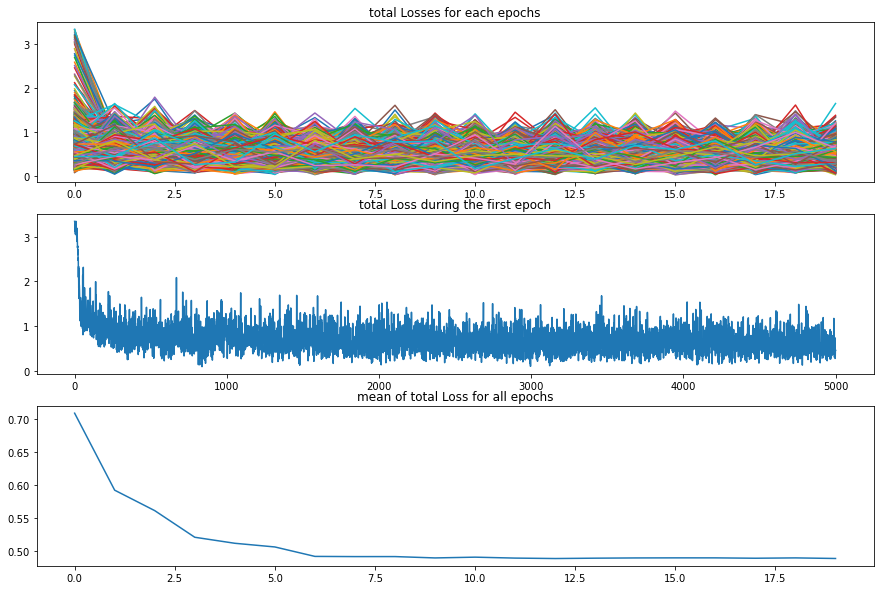

In [57]:
total_loss_to_plot=np.array(total_loss_to_plot)
mean_of_losses=total_loss_to_plot.mean(axis=1)
fig, axs = plt.subplots(3,figsize=(15, 10))


axs[0].plot(total_loss_to_plot)
axs[0].set_title('total Losses for each epochs')

axs[1].plot(total_loss_to_plot[0])
axs[1].set_title('total Loss during the first epoch')

axs[2].plot(mean_of_losses)
axs[2].set_title('mean of total Loss for all epochs')


# 4. save our model

In [35]:
torch.save(my_faster_rcnn.state_dict(), join(paths["MODEL_PATH"],"dict_pretrained_faster_rcnn.h"))

In [36]:
torch.save(my_faster_rcnn,join(paths["MODEL_PATH"],"full_pretrained_faster_rcnn.h"))